<a href="https://colab.research.google.com/github/amanteur/Network_Science_HSE/blob/main/competition_Random_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

## Basic Information

In [ ]:
baseline_stats = {"number_nodes": 1882, 
          "radius": [15, 2], 
          "diameter": [28, 4], 
          "average_clustering": [0.005066798238955518, 0.001], 
          "average_path_length": [11.748410823170731, 2], 
          "number_cc": [168, 32], 
          "degree_cdf": [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 24, 46], 
                         [0.0, 0.6902231668437833, 0.8517534537725824, 0.9086078639744952, 0.9378320935175345, 0.9516471838469713, 0.9654622741764081, 
                          0.9723698193411264, 0.9776833156216791, 0.9808714133900106, 0.9845908607863975, 0.9888416578108395, 0.9893730074388948, 
                          0.9925611052072264, 0.9936238044633369, 0.9952178533475027, 0.9957492029755579, 0.9968119022316685, 0.997874601487779, 
                          0.9989373007438895, 0.9994686503719448, 1.0]]}

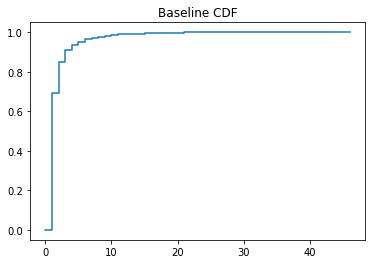

In [ ]:
q_seq, p_seq = baseline_stats['degree_cdf']
plt.plot(np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), np.repeat(p_seq, 2))
plt.title('Baseline CDF')
plt.show()

Trying to get degree histogram

In [ ]:
def get_degree_values(stats):

  probs_degree = np.array(stats['degree_cdf'][1])
  degrees = np.array(stats['degree_cdf'][0])
  number_nodes = stats['number_nodes']
  probs_degree[1:] -= probs_degree[:-1].copy()
  degree_hist = np.around(probs_degree*number_nodes).astype(int)

  return degree_hist, degrees

In [ ]:
degree_hist, degrees = get_degree_values(baseline_stats)
degree_dict = dict(zip(degrees, degree_hist))


## Additional functions

### Selecting gygantic component

In [ ]:
def select_gygantic_component(g: nx.Graph) -> nx.Graph:
  return g.subgraph(max(nx.connected_components(g), key=len)).copy()

### Finding shortest path length

In [ ]:
def get_avg_shortest_path_length(G):
  path_list = []
  for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
    path_list.append(nx.average_shortest_path_length(C))
  return sum(path_list)/len(path_list)

### Empirical CDF

In [ ]:
def empirical_cdf(g):
  return np.cumsum([prob/g.number_of_nodes() for prob in nx.degree_histogram(g)])

### CDF

In [ ]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return 1 + C * 1/(-alpha + 1) * x ** (-alpha + 1)

### Kolmogorov-Smirnov distance

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx

def prep_cdf_gt(degree_dist):
    dist = pd.Series(degree_dist[1])
    dist.index = degree_dist[0]
    dist = dist.reindex(range(dist.index.max() + 1))
    dist = dist.ffill()
    return lambda x: dist[x.astype(int)]

def prep_cdf_sub(G, maxval):
    dist = pd.Series(nx.degree_histogram(G)).reindex(range(maxval)).cumsum() / G.number_of_nodes()
    return lambda x: dist[x.astype(int)]


def calc_ks_stat(G, degree_dist):
    cdf1 = prep_cdf_gt(degree_dist)
    cdf2 = prep_cdf_sub(G, max(degree_dist[0]) + 1)
    degs = [i[1] for i in G.degree]
    x = np.linspace(min(degs), max(degs), G.number_of_nodes())
    return np.abs(cdf1(x) - cdf2(x)).max()

### Gaussian Kernel

In [ ]:
import math

def gk_dict(expected, actual, sigma): 
  """
  expected, actual, sigma - dict

  output - dict
  """

  return {k: (math.exp(-(expected[k]-actual[k])**2/(2*sigma[k]**2))) for k in actual}

## Main function

In [ ]:
def graph_model_check(n_nodes, prob, cdf_dict = None, stats_dict = None, baseline_stats_list = None, baseline = None):

  # modelling graph
  G = modified_random_graph(n_nodes, prob)
  # G = modified_random_graph_2(cdf_dict, n_nodes, prob)
  # G = nx.fast_gnp_random_graph(n_nodes, prob)
  # G = nx.powerlaw_cluster_graph(n_nodes, 1, prob)
  # G = nx.extended_barabasi_albert_graph(n_nodes, 3, prob, prob/2)
  # G = nx.watts_strogatz_graph(n_nodes, 25, prob)
  # G = gen_graph_conf_model(stats_dict)


  # getting giant component
  G_giant = select_gygantic_component(G)

  # getting baseline parameters
  radius = nx.radius(G_giant)
  diameter = nx.diameter(G_giant)
  number_cc = nx.number_connected_components(G)
  average_clustering = nx.average_clustering(G)
  average_path_length = nx.average_shortest_path_length(G_giant)
  # ks_test_metric = ks_test(G)
  ks_test_metric = 1 - calc_ks_stat(G, baseline_stats["degree_cdf"])


  actual_stats_dict = {"radius": radius,
                       "diameter": diameter,
                       "number_cc": number_cc,
                       "average_clustering": average_clustering,
                       "average_path_length": average_path_length}

  # unpacking baseline stats
  expected_stats_dict = {}
  sigmas_stats_dict = {}
  for stat in baseline_stats_list:
    ## expected
    expected_stats_dict[stat] = stats_dict[stat][0]
    ## sigmas
    sigmas_stats_dict[stat] = stats_dict[stat][1]

  # comparing to baseline stats
  gaussian_kernel_dict = gk_dict(actual_stats_dict, expected_stats_dict, sigmas_stats_dict)

  # total
  total = sum([gaussian_kernel_dict[key]*100/6 for key in gaussian_kernel_dict])+ks_test_metric*100/6

  #output
  if total >= baseline:
    print("Kolmogorov-Smirnov Statistic: {}\n".format(ks_test_metric))
    print("{:<25}{:<25}{:<25}{:<25}{:<25}".format("Stat", "Expected", "Actual", "Sigma", "GK"))
    for key in expected_stats_dict:
      print("\n{:<25}{:<25}{:<25}{:<25}{:<25}".format(key, 
                                      expected_stats_dict[key],
                                      actual_stats_dict[key],
                                      sigmas_stats_dict[key],
                                      gaussian_kernel_dict[key]))
    print("Total score: {}\n".format(total))

  return (G, total)

### Graph generating

In [ ]:
import random 

def modified_random_graph(n_nodes, prob):
  G = nx.fast_gnp_random_graph(n_nodes, prob)

  # dealing with isolated nodes
  isolated_nodes = np.array(list(nx.isolates(G)))
  G.add_edges_from(get_edges(isolated_nodes))

  
  #dealing with number of components
  while len(list(nx.connected_components(G)))>168:
    comp_list = []
    for comp in list(nx.connected_components(G)):
      if len(comp) < len(max(nx.connected_components(G), key=len)):
        comp_list.append(comp)
    comp_list_one = random.sample(comp_list, len(list(nx.connected_components(G))) - 168 + 1)
    nodes_from_sampled_comp = [item for sublist in comp_list_one for item in sublist]
    G.add_edges_from(get_edges(nodes_from_sampled_comp))
        
  return G

def get_edges(nodes):
  edge_list = []
  if len(nodes)//2 == 0:
    for i in range(0, len(nodes), 2):
      r = np.random.uniform(0,1)
      if r <= p:
        edge_list.append((nodes[i], nodes[i+1]))
  if len(nodes)//2 != 0:
    for i in range(0, len(nodes)-1, 2):
      # r = np.random.uniform(0,1)
      # if r <= p:
      edge_list.append((nodes[i], nodes[i+1]))
    rand_node_ind = random.randrange(0, len(nodes)-2, 2)
    edge_list.append((nodes[len(nodes)-1], nodes[rand_node_ind]))

  return np.array(edge_list)

## Main

In [ ]:
#variables
n_nodes = baseline_stats['number_nodes']
avg_edges = np.arange(1.8, 1.96, 0.02) #sum([k*v for k,v in degree_dict.items()])/1882 = 1.84~
prob = avg_edges/n_nodes
baseline_stats_list = ["radius", "diameter", "number_cc", "average_clustering", "average_path_length"]

total_list = []
bingo = False
#function
for i in range(10):
  for avg_edge in avg_edges:
    print("Epoch {:<5} Average edges = {}\n".format(i, avg_edge))
    prob = avg_edge/n_nodes
    g, total = graph_model_check(n_nodes=n_nodes, prob=prob, stats_dict=baseline_stats, baseline_stats_list=baseline_stats_list, baseline = 0)
    total_list.append((g, avg_edge, total))
    if total >= 95:
      bingo = True
      break
  if bingo:
    break
best = max(total_list,key=lambda item:item[2])

Epoch 0     Average edges = 1.8

Kolmogorov-Smirnov Statistic: 0.7003188097768331

Stat                     Expected                 Actual                   Sigma                    GK                       

radius                   15                       16                       2                        0.8824969025845955       

diameter                 28                       30                       4                        0.8824969025845955       

number_cc                168                      168                      32                       1.0                      

average_clustering       0.005066798238955518     0.01350387126157583      0.001                    3.4877641750292936e-16   

average_path_length      11.748410823170731       11.664901929072757       2                        0.9991286629106371       
Total score: 74.40735463094437

Epoch 0     Average edges = 1.82

Kolmogorov-Smirnov Statistic: 0.6992561105207226

Stat                     Expected       

### Output to the file

In [ ]:
print(best[:3])

(<networkx.classes.graph.Graph object at 0x7fcd30cbca90>, 1.9000000000000001, 91.5891088867529)


In [ ]:
from google.colab import files

def graph_edges_output(G, filename = 'output.txt'):
  edges = G.edges
  with open(filename, 'w') as f:
    f.write('\n'.join('%s %s' % x for x in edges))
  files.download(filename)
  print('Done!')


In [ ]:
graph_edges_output(best[0], 'edges.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done!


### Plot

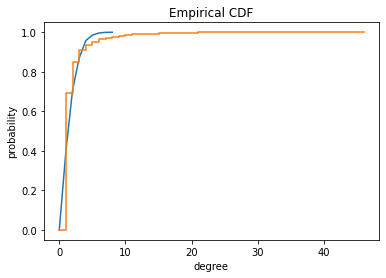

In [ ]:
кaq_seq, p_seq = baseline_stats['degree_cdf']
plt.plot(empirical_cdf(g))
plt.plot(np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), np.repeat(p_seq, 2))
plt.xlabel('degree')
plt.ylabel('probability')
plt.title('Empirical CDF')
plt.show()

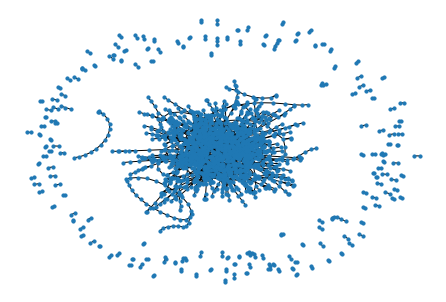

In [ ]:
nx.draw(g, node_size=10)

Text(0, 0.5, 'Frequency')

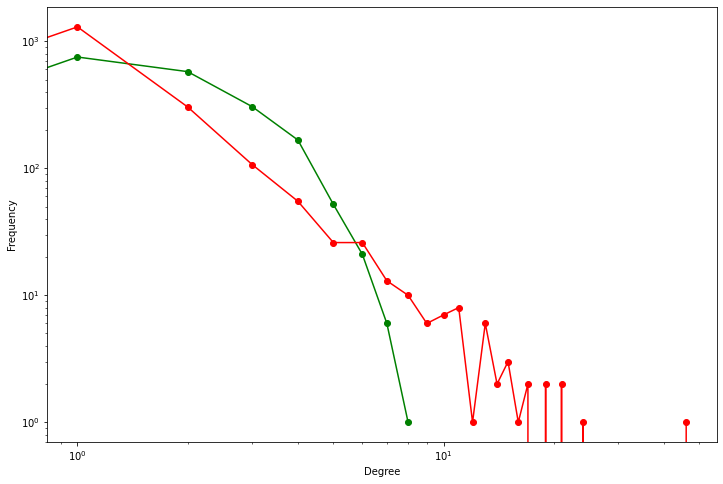

In [ ]:
degree_freq = nx.degree_histogram(g)
degrees = range(len(degree_freq))
expected_degree_freq = [degree_dict[i] if i in degree_dict else 0 for i in range(47)]
expected_degrees = range(len(expected_degree_freq))

plt.figure(figsize=(12, 8)) 
plt.loglog(degrees, degree_freq,'go-') 
plt.loglog(expected_degrees, expected_degree_freq,'ro-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')

### Testing

In [ ]:
print("LB score:", 1 - calc_ks_stat(best[0], baseline_stats["degree_cdf"]))

LB score: 0.7093517534537725
